# Обучение модели в Tensorflow

На прошлом уроке мы узнали, как описывать модель. Теперь мы должны понять как определять две другие важные составляющие пайплайна -- лосс функцию и оптимизатор. И наконец, понять как это все соединить вместе.

## Определение лосс функции

На протяжении курса вы познакомились как минимум с тремя типами функций потерь


*   MSE (mean squared error) -- для задачи регрессии
*   BCE (binary cross entropy) -- для задачи бинарной классификации
*   Categorical cross entropy -- для задачи многоклассовой классификации

Все они реализованы в Keras и находятся в tf.keras.losses:
*   tf.keras.losses.MSE()
*   tf.keras.losses.binary_crossentropy()
*   tf.keras.losses.sparse_categorical_crossentropy()


In [2]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
#tf.enable_eager_execution()

In [3]:
import numpy as np

y_true = np.random.rand(10)
y_pred = np.random.rand(10)

# MSE
# лосс функция принимает предсказанные значение и реальные, и возвращает значение, которое в идеале должно быть близко к 0 -- все просто
print(tf.keras.losses.MSE(y_true=y_true, y_pred=y_pred))

tf.Tensor(0.19019291890480566, shape=(), dtype=float64)


2024-05-02 14:41:03.502145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 14:41:03.558837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 14:41:03.559102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# Можно проверить, правильно ли MSE реализована в Keras :)
print(np.mean((y_true - y_pred)**2))

0.19019291890480566


In [5]:
# BCE

print(tf.keras.losses.binary_crossentropy(np.ones(10), np.ones(10)))

loss = tf.keras.losses.BinaryCrossentropy()
print(loss(np.ones(10), np.ones(10)))

tf.Tensor(1.0000000494736472e-07, shape=(), dtype=float64)
tf.Tensor(1.192093e-07, shape=(), dtype=float32)


Но у некоторых функций есть особенности -- например у sparse_categorical_crossentropy. Взгляните на ее сигнатуру ниже:

*Если в Colab написать знак вопроса после функции, можно получить ее сигнатуру и описание входных переменных*

In [6]:
tf.keras.losses.SparseCategoricalCrossentropy?

# обратите внимание на from_logits=False, аналогично в tf.keras.losses.BinaryCrossentropy

Init signature:
tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    ignore_class=None,
    reduction='sum_over_batch_size',
    name='sparse_categorical_crossentropy',
)
Docstring:     
Computes the crossentropy loss between the labels and predictions.

Use this crossentropy loss function when there are two or more label
classes.  We expect labels to be provided as integers. If you want to
provide labels using `one-hot` representation, please use
`CategoricalCrossentropy` loss.  There should be `# classes` floating point
values per feature for `y_pred` and a single floating point value per
feature for `y_true`.

In the snippet below, there is a single floating point value per example for
`y_true` and `num_classes` floating pointing values per example for
`y_pred`. The shape of `y_true` is `[batch_size]` and the shape of `y_pred`
is `[batch_size, num_classes]`.

Args:
    from_logits: Whether `y_pred` is expected to be a logits tensor. By
        default, we assume

Обратите внимание, что она принимает дополнительный параметр -- from_logits. Здесь стоит напомнить, что данную лосс функцию можно считать двумя способами -- из предсказанных вероятностей и из предсказанных логитов. *Мы использовали этот трюк в последнем домашнем задании*.

Напомню, что сеть изначально предсказывает логиты, и затем мы превращаем их в вероятности --  с помощью функции активации. Но т.к. мы знаем, что нам предстоит считать лосс, то мы можем не тратить "силы" на вычисление вероятностей и посчитать лосс основываясь на логитах (логарифм + экспонента сильно упрощают запись). Мы как бы перебросили активацию из слоя в лосс и оставили “голый” слой без активации. Такая запись проще и вычислительно более стабильная.


**Важно помнить, что в случае использования логитов (from_logits=True), последний слой должен быть без активации. Это очень распространенная ошибка. Всегда помните об этом.**

Ниже приведем небольшую шпаргалку о том, как комбинировать активацию последнего слоя с лосс функцией:

*Для задачи классификации*
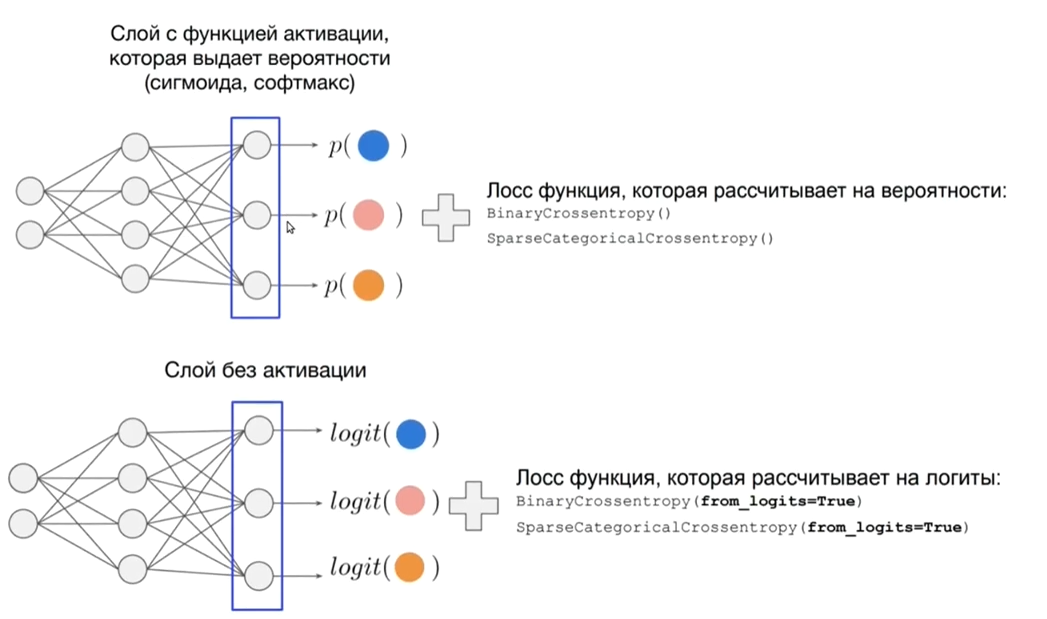
<br>
*Для задачи регрессии*
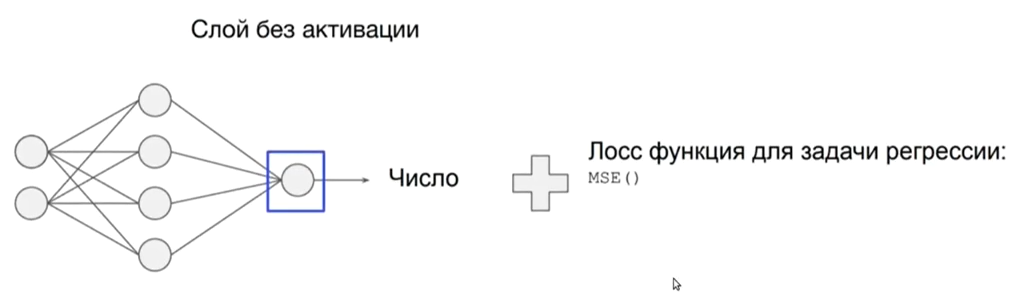

## Определение оптимизатора

С оптимизатором -- все аналогично. Они живут в tf.keras.optimizers. Например:
*  tf.keras.optimizers.Adam
*  tf.keras.optimizers.SGD и многие другие.

Каждый из оптимизаторов имеет свои параметры, но все разделяют общий -- learning rate.

In [7]:
tf.keras.optimizers.Adam, tf.keras.optimizers.SGD()

(keras.src.optimizers.adam.Adam,
 <keras.src.optimizers.sgd.SGD at 0x78adea060740>)

# Собираем все вместе

## Задача регрессии

Рассмотрим простую задачу определения коэффициентов зависимости шкалы фаренгейта от цельсия. Это классическая формулировка задачи линейной регрессии. Известно, что эта зависимость линейная -- давайте посчитаем ее параметры, исходя из данных:

In [8]:
import tensorflow as tf
import numpy as np

print(tf.__version__)

# определим наш скромный датасет
celsius = np.array([-10, -40, 10, 20, 36, 5, -12, 14, 36]).astype(np.float32)
fahrenheit = np.array([14., -40., 50., 68., 96.8, 41., 10.4, 57.2, 96.8])

2.16.1


In [9]:
model = tf.keras.Sequential() # модель состоит из одного слоя с одним выходом и входом.
model.add(tf.keras.layers.Dense(1, input_shape=(1,)))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)
loss = tf.keras.losses.MSE

/mnt/500_gb/data_science/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# cледующий шаг -- компиляция модели: "связываем" модель, оптимайзер и лосс
model.compile(optimizer=optimizer, loss=loss)

In [11]:
# и наконец, обучение модели с помощью метода model.fit.

model.fit?

Signature:
model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)
Docstring:
Trains the model for a fixed number of epochs (dataset iterations).

Args:
    x: Input data. It could be:
        - A NumPy array (or array-like), or a list of arrays
        (in case the model has multiple inputs).
        - A tensor, or a list of tensors
        (in case the model has multiple inputs).
        - A dict mapping input names to the corresponding array/tensors,
        if the model has named inputs.
        - A `tf.data.Dataset`. Should return a tuple
        of either `(inputs, targets)` or
        `(inputs, targets, sample_weights)`.
        - A `keras.utils.PyDataset` returning `(inputs,
      

 Сигнатура выглядит следующим образом (часть параметров, которые мы не будем использовать в ближайшее время скрыта).

```
model.fit(x=None, y=None, batch_size=None, epochs=1, validation_data=None, shuffle=True, ...)
```

*   x, y -- обучающая выборка, входные признаки и ответы
*   batch_size -- размер батча при обучении
*   epochs -- количество эпох
*   validation_data -- данные для валидации, например, (x_val, y_val)
*   shuffle -- перемешивать данные при обучении или нет




In [12]:
history = model.fit(celsius, fahrenheit, epochs=200, verbose=2)

Epoch 1/200
1/1 - 0s - 457ms/step - loss: 6329.8853
Epoch 2/200
1/1 - 0s - 15ms/step - loss: 4670.7686
Epoch 3/200
1/1 - 0s - 14ms/step - loss: 3315.5610
Epoch 4/200


I0000 00:00:1714650721.461316   73381 service.cc:145] XLA service 0x78accc005580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714650721.461356   73381 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-05-02 14:52:01.473139: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-02 14:52:01.528134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1714650721.616487   73381 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 - 0s - 14ms/step - loss: 2264.6602
Epoch 5/200
1/1 - 0s - 13ms/step - loss: 1510.6649
Epoch 6/200
1/1 - 0s - 14ms/step - loss: 1035.0802
Epoch 7/200
1/1 - 0s - 13ms/step - loss: 805.1560
Epoch 8/200
1/1 - 0s - 13ms/step - loss: 772.3097
Epoch 9/200
1/1 - 0s - 14ms/step - loss: 874.3874
Epoch 10/200
1/1 - 0s - 14ms/step - loss: 1043.2003
Epoch 11/200
1/1 - 0s - 14ms/step - loss: 1215.8278
Epoch 12/200
1/1 - 0s - 14ms/step - loss: 1345.1254
Epoch 13/200
1/1 - 0s - 14ms/step - loss: 1405.0236
Epoch 14/200
1/1 - 0s - 14ms/step - loss: 1389.6116
Epoch 15/200
1/1 - 0s - 14ms/step - loss: 1308.2087
Epoch 16/200
1/1 - 0s - 14ms/step - loss: 1179.2762
Epoch 17/200
1/1 - 0s - 14ms/step - loss: 1024.9879
Epoch 18/200
1/1 - 0s - 14ms/step - loss: 867.0837
Epoch 19/200
1/1 - 0s - 14ms/step - loss: 723.9794
Epoch 20/200
1/1 - 0s - 14ms/step - loss: 608.9315
Epoch 21/200
1/1 - 0s - 14ms/step - loss: 529.0937
Epoch 22/200
1/1 - 0s - 15ms/step - loss: 485.3964
Epoch 23/200
1/1 - 0s - 14ms/step - lo

Модель обучена. Для того, чтобы узнать итоговые коэффициенты, воcпользуемся model.get_weights()

In [13]:
model.get_weights()

[array([[1.7998649]], dtype=float32), array([32.009857], dtype=float32)]

В реальности эти две шкалы связаны формулой:
$$
F = 1.8C + 32
$$

Неудивительно, что мы получили правильные коэффициенты ;)


**История обучения**

Помимо обучения модели и прогресс бара, model.fit(...), возвращает полезный объект -- историю. Давайте взглянем на нее ближе.

In [14]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.head()

,loss
0,6329.885254
1,4670.768555
2,3315.561035
3,2264.660156
4,1510.664917


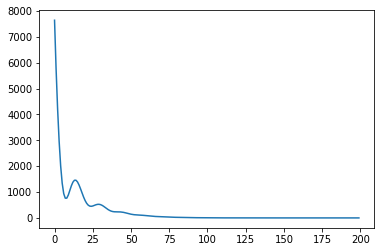

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss)

На графике можно увидеть как менялся лосс на протяжении 200 эпох. Можно заметить, что обучение можно было остановить после 100 эпохи.


## Задача классификации

In [16]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from sklearn.metrics import accuracy_score


%matplotlib inline
np.random.seed(10)

colors = ['red', "blue"]
labels_cmap = ListedColormap(colors, 2)
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
main_cmap = LinearSegmentedColormap.from_list("main_scheme", colors, N=300)

def show_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], s=120, color=labels_cmap(y))


def show_descision_boundary(clf, limits, binary=False, X=None, y=None, n_lines=10, show_lines=False,
                           figsize=(5, 5), ax=None):
    xs, ys = limits
    x_min, x_max = xs
    y_min, y_max = ys

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)

    if binary:
        Z = clf.predict_class(np.c_[xx.ravel(), xx.ravel()])
        Z = clf.predict_class(np.c_[xx.ravel(), yy.ravel()])
        norm = Normalize(vmin=0.,vmax=1.)
    else:
        Z = clf(np.c_[xx.ravel(), xx.ravel()])
        Z = clf(np.c_[xx.ravel(), yy.ravel()])
        #if clf.prob_output:
        #    norm = Normalize(vmin=0.,vmax=1.)
        #else:
        norm = Normalize(vmin=-10.,vmax=10., clip=True)
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    Z = Z.astype(np.float32)

    ax.contourf(xx, yy, Z, n_lines, alpha=0.4, cmap=main_cmap, norm=norm)
    if show_lines:
        cp = ax.contour(xx, yy, Z, n_lines)
        ax.clabel(cp, inline=True,
              fontsize=10, colors="green")

    if y is not None:
        X = np.array(X)
        y = np.array(y)
        ax.scatter(X[:, 0], X[:, 1], s=120, color=labels_cmap(y),
                   zorder=4)



Аналогично можно решить задачу классификации. Помните эту выборку? Мы пытались ее разделить тремя нейронами самостоятельно в самом первом модуле! Давайте теперь сделаем это с помощью Tensorflow.

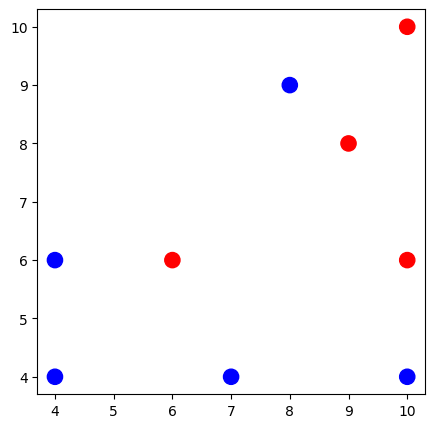

In [17]:
X = np.array([[10, 6], [7, 4], [6, 6], [9, 8], [10, 10],
              [10, 4], [4, 4], [4, 6], [8, 9]])
y = np.array([0, 1, 0, 0, 0, 1, 1, 1, 1])
show_data(X, y)

Без каких-либо сложностей, мы преобразуем модель в модель для классификации. Для этого нужно изменить лосс функцию и функцию активации последнего слоя.

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(4, input_shape=(2,), activation="sigmoid"))
model.add(tf.keras.layers.Dense(1)) # мы хотим визуализировать логиты, поэтому без активации

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) # лосс -- с логитами

/mnt/500_gb/data_science/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


При компиляции модели добавим еще одно поле -- **metrics**. Метрики не влияют на обучение, но очень полезны для его контроля. Например, обучая классификатор удобно смотреть не только на лосс, но и на точность.

In [19]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) # для дополнительного контроля
                                                                    #-- просим сообщать не только лосс, но и точность.
history = model.fit(X, y, epochs=100, verbose=2)

Epoch 1/100
1/1 - 1s - 855ms/step - accuracy: 0.4444 - loss: 0.7181
Epoch 2/100
1/1 - 0s - 15ms/step - accuracy: 0.4444 - loss: 0.6979
Epoch 3/100
1/1 - 0s - 15ms/step - accuracy: 0.4444 - loss: 0.6865
Epoch 4/100
1/1 - 0s - 14ms/step - accuracy: 0.4444 - loss: 0.6796
Epoch 5/100
1/1 - 0s - 15ms/step - accuracy: 0.4444 - loss: 0.6706
Epoch 6/100
1/1 - 0s - 14ms/step - accuracy: 0.4444 - loss: 0.6586
Epoch 7/100
1/1 - 0s - 16ms/step - accuracy: 0.4444 - loss: 0.6481
Epoch 8/100
1/1 - 0s - 15ms/step - accuracy: 0.5556 - loss: 0.6437
Epoch 9/100
1/1 - 0s - 15ms/step - accuracy: 0.6667 - loss: 0.6449
Epoch 10/100
1/1 - 0s - 15ms/step - accuracy: 0.7778 - loss: 0.6430
Epoch 11/100
1/1 - 0s - 15ms/step - accuracy: 0.6667 - loss: 0.6388
Epoch 12/100
1/1 - 0s - 16ms/step - accuracy: 0.6667 - loss: 0.6346
Epoch 13/100
1/1 - 0s - 15ms/step - accuracy: 0.5556 - loss: 0.6315
Epoch 14/100
1/1 - 0s - 15ms/step - accuracy: 0.5556 - loss: 0.6289
Epoch 15/100
1/1 - 0s - 15ms/step - accuracy: 0.5556 - l

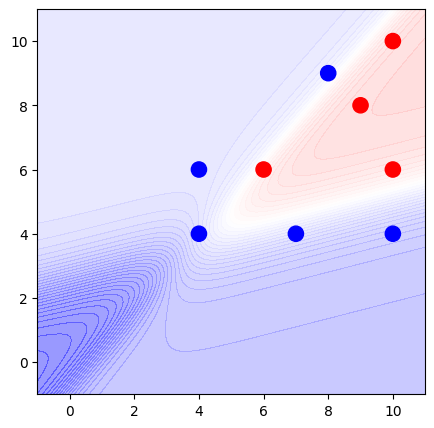

In [20]:
limits = [[-1, 11], [-1, 11]]

show_descision_boundary(limits=limits, clf=model, binary=False,
                                X=X,
                                y=y,
                                n_lines=50,
                                show_lines=False)

In [21]:
pd.DataFrame(history.history).head()

,accuracy,loss
0,0.444444,0.718073
1,0.444444,0.697860
2,0.444444,0.686543
3,0.444444,0.679621
4,0.444444,0.670618


## Рекомендации к практическому заданию
В следующем практическом задании перед вами будет стоять задача обучения сетей для синтетических данных. Для этого вам нужно будет подобрать самим количество слоев, количество нейронов и скорость обучения. **Как это сделать?** К сожалению, однозначного ответа на этот вопрос нет.

Чем сложнее задача, тем сложнее должна быть архитектура. Сложность архитектуры зависит от количества слоев и нейронов. Задачи, которые вас ждут с ближайшей практике, данные не слишком сложные -- поэтому не переусердствуйте. *Начните с одного слоя, понаблюдайте, как изменяется точность, добавьте еще один, если понадобится. Экспериментируйте!*

Но это не единственный рычаг, который можно двигать. Еще есть скорость обучения. Если вы замечаете при обучении, что ошибка не меняется, но архитектура должна справиться, то возможно скорость обучения слишком маленькая. Обычно она находится в диапазоне 0.0001-0.1.

В реальных задачах глубина сети, количество нейронов, скорость обучения -- это гиперпараметры, которые нужно подбирать наблюдая за качеством на валидационной выборкой.


#Заключение
В этом уроке мы научились:


1.   Определять лосс функцию
2.   Определять оптимизатор
3.   Компилировать и обучать модель для задачи классификации и регрессии.

Теперь вы можете перейти к практике для закрепления материала: [ссылка](https://colab.research.google.com/drive/11pzWQSauLzuoUPyRW10zV1p7o4NKMVB7).

